In [39]:
import pandas as pd
import torch
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import sys
import os
from tqdm import tqdm

import torch.nn as nn
import numpy as np
import torch.utils.data as Data
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import log_loss, roc_auc_score
from collections import OrderedDict, namedtuple, defaultdict
import random

data_path = '../../data/ctr-criteo-small-data/train_1m.txt'
# 数据说明：https://www.kaggle.com/competitions/criteo-display-ad-challenge/data

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 定义模型结构 FM & dnn

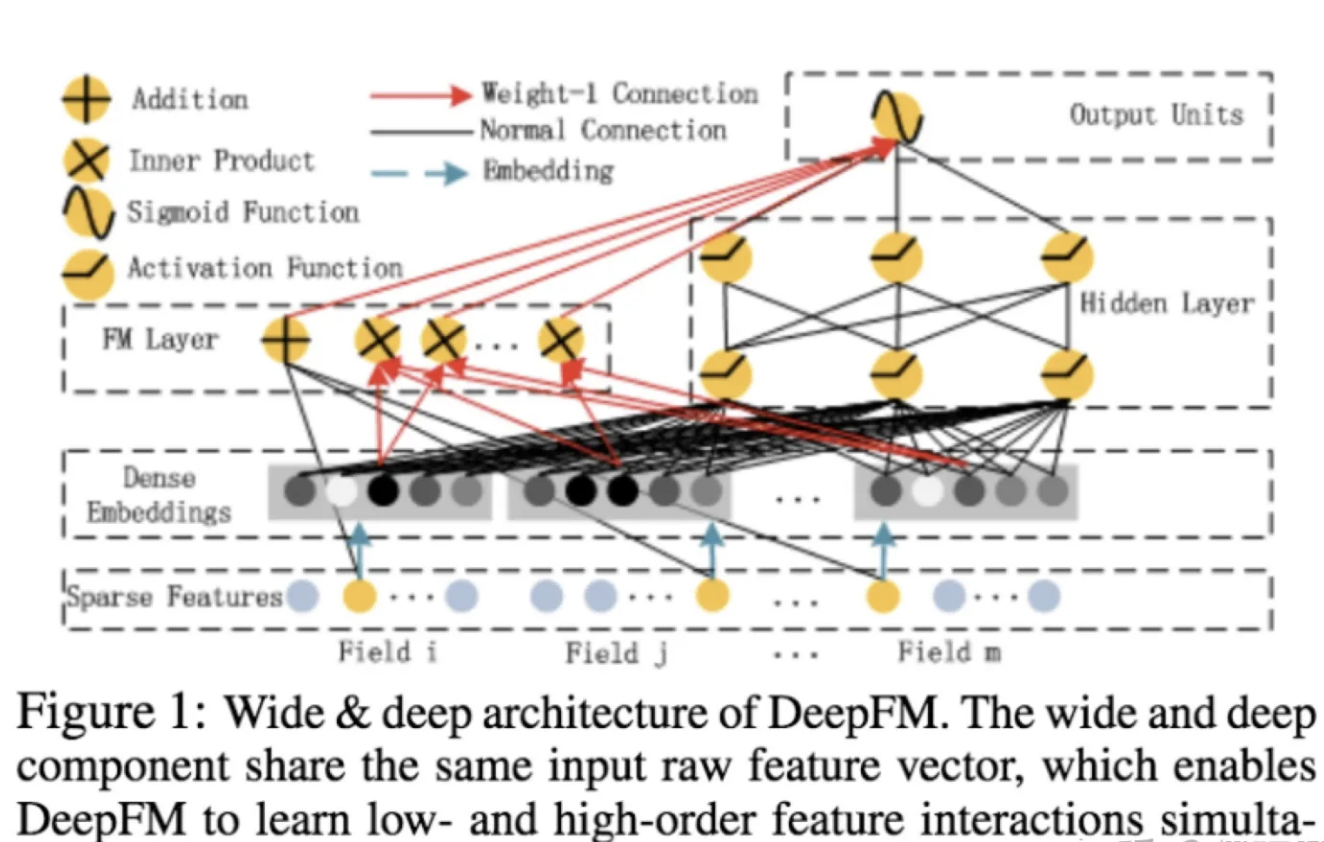

- 知乎：https://zhuanlan.zhihu.com/p/57873613

## FM部分


- 知乎【如何简化计算FM复杂度】：https://zhuanlan.zhihu.com/p/58160982

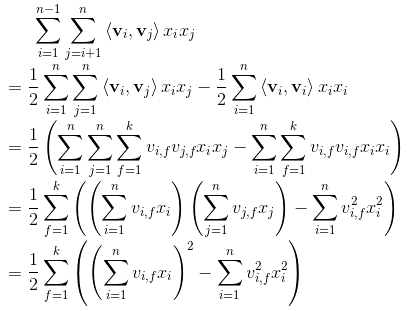

In [3]:
class FM(nn.Module):

    def __init__(self, latent_dim, feature_dim):
        """

        :param latent_dim: FM 的v，作为交互的隐向量
        :param feature_dim: 特征维度 x [batch_size, feature_num]
        """
        super(FM, self).__init__()

        self.latent_dim = latent_dim
        self.feature_dim = feature_dim

        self.w0 = nn.Parameter(torch.zeros(1,))
        self.w1 = nn.Parameter(torch.zeros([self.feature_dim, 1]))
        self.w2 = nn.Parameter(torch.zeros([self.feature_dim,
                                            self.latent_dim]))
#         self.w2.data.uniform(-0.01,0.01)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x: [batch, feature_dim]
        first_order = self.w0 + torch.mm(x, self.w1) 
        # shape = [batch, 1]
        second_order = 1 / 2 * torch.sum(
            torch.pow(torch.mm(x, self.w2), 2) - torch.mm(torch.pow(x, 2),
            torch.pow(self.w2, 2)),
            dim=1, keepdim=True) # shape = [batch, 1]
        second_order = self.dropout(second_order)
        res = first_order + second_order
        # res = torch.sigmoid(res)
        return res

In [4]:
tmp = torch.tensor([[1,2,7,8],[3,4,5,4],[5,6,8,9]])
fm = FM(10,4)

In [5]:
fm(tmp.float())

tensor([[0.],
        [0.],
        [0.]], grad_fn=<AddBackward0>)

## 整合为deepFM部分

In [25]:
class deepfm(nn.Module):
    
    def __init__(self, feat_sizes, sparse_feature_columns, dense_feature_columns,
                 dnn_hidden_units=[400, 400,400], dnn_dropout=0.3, embedding_size=4,
                 l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0,
                 init_std=0.0001, seed=1024, device='cuda'):
        super(deepfm, self).__init__()
        self.feat_sizes = feat_sizes
        self.device = device
        self.dense_feature_columns = dense_feature_columns
        self.sparse_feature_columns = sparse_feature_columns
        self.embedding_size = embedding_size
        self.l2_reg_linear = l2_reg_linear
        
        self.bias = nn.Parameter(torch.zeros((1, )))
        self.init_std = init_std
        self.dnn_dropout = dnn_dropout
        
        # 在sparse的特征当中，维护一个emb的dict，key=feature名称
        self.embedding_dic = nn.ModuleDict({
            feat:nn.Embedding(self.feat_sizes[feat],self.embedding_size,sparse=False)
            for feat in self.sparse_feature_columns
        })
        
        for curr in self.embedding_dic.values():
            nn.init.normal_(curr.weight, mean=0, std=self.init_std)
        self.embedding_dic.to(self.device)
        
        self.feature_index = defaultdict(int)
        start = 0
        for feat in self.feat_sizes:
            if feat in self.feature_index:
                continue
            self.feature_index[feat] = start
            start += 1
        
        # 输入维度
        self.input_size = self.embedding_size * len(self.sparse_feature_columns) + \
            len(self.dense_feature_columns)
        
        # FM
        self.fm = FM(10, self.input_size)
        
        # DNN
        self.dropout = nn.Dropout(self.dnn_dropout)
        self.hidden_units = [self.input_size] + dnn_hidden_units
        self.Linears = nn.ModuleList([
            nn.Linear(self.hidden_units[i], self.hidden_units[i+1])
            for i in range(len(self.hidden_units)-1)
        ])
        self.relus = nn.ModuleList([nn.ReLU() for i in range(len(self.hidden_units)-1)])
        for name, curr in self.Linears.named_parameters():
            if 'weight' in name:
                nn.init.normal_(curr, mean=0, std=self.init_std)
        self.dnn_outlayer = nn.Linear(dnn_hidden_units[-1],1,bias=False).to(self.device)
        
    def forward(self, x):
        # x: [batch, feature_dim] = [*, 39]
        sparse_embedding = [self.embedding_dic[feat](x[:, self.feature_index[feat]].long())
                           for feat in self.sparse_feature_columns]
        sparse_embedding = torch.cat(sparse_embedding, dim = -1)
        # sparse_embedding: [batch, sparse_features_num * embedding_size] ?
        
        dense_value = [x[:, self.feature_index[feat]] for feat in self.dense_feature_columns]
        # dense_value: [[batch,1],[batch,1],...]
        dense_value = torch.cat(dense_value, dim=0)
        dense_value = torch.reshape(dense_value, (len(self.dense_feature_columns), -1))
        dense_value = dense_value.T # [batch, dense_features_num (=13)]
        
        input_x = torch.cat((dense_value, sparse_embedding), dim=1)
        # input_x: [batch, dense_features_num+sparse_features_num * embedding_size]
        
        fm_logit = self.fm(input_x)
        
        for i in range(len(self.Linears)):
            fc = self.Linears[i](input_x)
            fc = self.relus[i](fc)
            fc = self.dropout(fc)
            input_x = fc
        dnn_logit = self.dnn_outlayer(input_x)
        
        y_pre = torch.sigmoid(fm_logit + dnn_logit + self.bias)
        return y_pre

# 获取数据 criteo-small

In [8]:
data = pd.read_csv(data_path, sep='\t', header=None)
print(data.shape)

(1000000, 40)


In [9]:
# 规定
dense_features = ['I'+str(i+1) for i in range(13)]
sparse_features = ['C'+str(i+1) for i in range(26)]
cols = ['label'] + dense_features + sparse_features
# 其中C1-C26是Category的特征(sparse_features)，而I1-I13是连续的特征(dense_features)。
data.columns = cols

In [10]:
# 因为有缺失的值，我们把Category的缺失值设置为”-1”，而把连续的缺失值设置为0。
data[sparse_features] = data[sparse_features].fillna('-1')
data[dense_features] = data[dense_features].fillna(0)

In [12]:
# 类别型的encoder
for col in sparse_features:
    enc = LabelEncoder()
    data[col] = enc.fit_transform(data[col])

In [13]:
# 连续值：缩放到0-1范围
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [14]:
data.head(3)

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,0.001282,0.000162,0.000076,0.000000,0.000547,0.000017,0.001703,0.000395,0.009365,...,9,3691,227,3,7339,0,3,31852,58,18184
1,0,0.002564,0.000108,0.000671,0.001972,0.000040,0.000034,0.000227,0.000395,0.000207,...,0,2657,227,1,91082,0,3,10872,58,13709
2,0,0.002564,0.000108,0.000015,0.027613,0.000304,0.000381,0.000454,0.000395,0.012677,...,6,789,0,0,215785,10,3,9478,0,0


In [15]:
feat_size1 = {feat: 1 for feat in dense_features}
feat_size2 = {feat: len(data[feat].unique()) for feat in sparse_features}
feat_sizes = {}
feat_sizes.update(feat_size1)
feat_sizes.update(feat_size2)
print(feat_sizes) # 每个特征field对应有多少类别（忽略了连续型特征，只看类别型）

{'I1': 1, 'I2': 1, 'I3': 1, 'I4': 1, 'I5': 1, 'I6': 1, 'I7': 1, 'I8': 1, 'I9': 1, 'I10': 1, 'I11': 1, 'I12': 1, 'I13': 1, 'C1': 1261, 'C2': 531, 'C3': 321439, 'C4': 120965, 'C5': 267, 'C6': 16, 'C7': 10863, 'C8': 563, 'C9': 3, 'C10': 30792, 'C11': 4731, 'C12': 268488, 'C13': 3068, 'C14': 26, 'C15': 8934, 'C16': 205924, 'C17': 10, 'C18': 3881, 'C19': 1855, 'C20': 4, 'C21': 240748, 'C22': 16, 'C23': 15, 'C24': 41283, 'C25': 70, 'C26': 30956}


In [16]:
train, test =train_test_split(data, test_size=0.2, random_state=2021)
feature_names = dense_features + sparse_features
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

# 模型超参设定

In [41]:
batch_size = 512
lr = 5e-4
wd = 1e-5
epoches = 50

seed = 1024
torch.manual_seed(seed)  # 为CPU设置随机种子
torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)  # 为所有GPU设置随机种子
np.random.seed(seed)
random.seed(seed)

def test_auc(loader, model):
    pred, target = [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device).float()
            y = y.to(device).float()
            y_hat = model(x)
            pred += list(y_hat.cpu().numpy())
            target += list(y.cpu().numpy())
    auc = roc_auc_score(target, pred)
    return auc

In [42]:
model = deepfm(feat_sizes=feat_sizes,
               sparse_feature_columns=sparse_features, 
               dense_feature_columns=dense_features,
               dnn_hidden_units=[1000,500,250],
               dnn_dropout=0.8,
               embedding_size=16,
               l2_reg_linear=1e-3,
               device=device)
# 429 = 13 + 26 * 16
# (Linears): ModuleList(
#     (0): Linear(in_features=429, out_features=1000, bias=True)
#     (1): Linear(in_features=1000, out_features=500, bias=True)
#     (2): Linear(in_features=500, out_features=250, bias=True)
#   )

In [43]:
model.to(device)

deepfm(
  (embedding_dic): ModuleDict(
    (C1): Embedding(1261, 16)
    (C10): Embedding(30792, 16)
    (C11): Embedding(4731, 16)
    (C12): Embedding(268488, 16)
    (C13): Embedding(3068, 16)
    (C14): Embedding(26, 16)
    (C15): Embedding(8934, 16)
    (C16): Embedding(205924, 16)
    (C17): Embedding(10, 16)
    (C18): Embedding(3881, 16)
    (C19): Embedding(1855, 16)
    (C2): Embedding(531, 16)
    (C20): Embedding(4, 16)
    (C21): Embedding(240748, 16)
    (C22): Embedding(16, 16)
    (C23): Embedding(15, 16)
    (C24): Embedding(41283, 16)
    (C25): Embedding(70, 16)
    (C26): Embedding(30956, 16)
    (C3): Embedding(321439, 16)
    (C4): Embedding(120965, 16)
    (C5): Embedding(267, 16)
    (C6): Embedding(16, 16)
    (C7): Embedding(10863, 16)
    (C8): Embedding(563, 16)
    (C9): Embedding(3, 16)
  )
  (fm): FM(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (Linears): ModuleList(
    (0): Linear(in_features=429, out_f

# 数据loader

In [44]:
train_label = pd.DataFrame(train['label'])
train_data = train.drop(columns=['label'])
#print(train.head(5))
train_tensor_data = torch.utils.data.TensorDataset(
    torch.from_numpy(np.array(train_data)), torch.from_numpy(np.array(train_label)))
train_loader = DataLoader(dataset=train_tensor_data, shuffle=True, batch_size=batch_size)

test_label = pd.DataFrame(test['label'])
test_data = test.drop(columns=['label'])
test_tensor_data = torch.utils.data.TensorDataset(torch.from_numpy(np.array(test_data)),
                                                   torch.from_numpy(np.array(test_label)))
test_loader = DataLoader(dataset=test_tensor_data, shuffle=False, batch_size=batch_size)

In [45]:
next(iter(train_loader))[0].size()

torch.Size([512, 39])

# 训练设定

In [46]:
loss_func = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
for epoch in tqdm(range(epoches)):
    total_loss_epoch = 0.0
    total_tmp = 0

    model.train()
    for index, (x, y) in enumerate(train_loader):
        x = x.to(device).float()
        y = y.to(device).float()

        y_hat = model(x)

        optimizer.zero_grad()
        loss = loss_func(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss_epoch += loss.item()
        total_tmp += 1

    auc = test_auc(test_loader, model)
    print('epoch/epoches: {}/{}, train loss: {:.3f}, test auc: {:.3f}'.format(
        epoch, epoches, total_loss_epoch / total_tmp, auc))

  2%|▏         | 1/50 [00:36<29:52, 36.57s/it]

epoch/epoches: 0/50, train loss: 0.493, test auc: 0.770


  4%|▍         | 2/50 [01:14<29:41, 37.11s/it]

epoch/epoches: 1/50, train loss: 0.404, test auc: 0.727


  6%|▌         | 3/50 [01:53<29:28, 37.63s/it]

epoch/epoches: 2/50, train loss: 0.407, test auc: 0.752


  8%|▊         | 4/50 [02:33<29:13, 38.12s/it]

epoch/epoches: 3/50, train loss: 0.348, test auc: 0.716


 10%|█         | 5/50 [03:09<28:18, 37.75s/it]

epoch/epoches: 4/50, train loss: 0.328, test auc: 0.713


 12%|█▏        | 6/50 [03:45<27:09, 37.04s/it]

epoch/epoches: 5/50, train loss: 0.324, test auc: 0.709


 14%|█▍        | 7/50 [04:24<26:57, 37.62s/it]

epoch/epoches: 6/50, train loss: 0.326, test auc: 0.720


 16%|█▌        | 8/50 [05:01<26:13, 37.47s/it]

epoch/epoches: 7/50, train loss: 0.326, test auc: 0.715


 18%|█▊        | 9/50 [05:40<25:50, 37.81s/it]

epoch/epoches: 8/50, train loss: 0.320, test auc: 0.706


 20%|██        | 10/50 [06:17<25:12, 37.81s/it]

epoch/epoches: 9/50, train loss: 0.317, test auc: 0.697


 22%|██▏       | 11/50 [06:55<24:37, 37.88s/it]

epoch/epoches: 10/50, train loss: 0.314, test auc: 0.717


 24%|██▍       | 12/50 [07:31<23:29, 37.10s/it]

epoch/epoches: 11/50, train loss: 0.311, test auc: 0.718


 26%|██▌       | 13/50 [08:08<22:59, 37.29s/it]

epoch/epoches: 12/50, train loss: 0.307, test auc: 0.695


 28%|██▊       | 14/50 [08:45<22:12, 37.01s/it]

epoch/epoches: 13/50, train loss: 0.305, test auc: 0.700


 30%|███       | 15/50 [09:25<22:08, 37.94s/it]

epoch/epoches: 14/50, train loss: 0.301, test auc: 0.700


 32%|███▏      | 16/50 [10:01<21:12, 37.43s/it]

epoch/epoches: 15/50, train loss: 0.298, test auc: 0.705


 34%|███▍      | 17/50 [10:37<20:21, 37.02s/it]

epoch/epoches: 16/50, train loss: 0.295, test auc: 0.693


 36%|███▌      | 18/50 [11:13<19:37, 36.80s/it]

epoch/epoches: 17/50, train loss: 0.291, test auc: 0.713


 38%|███▊      | 19/50 [11:50<18:59, 36.77s/it]

epoch/epoches: 18/50, train loss: 0.288, test auc: 0.696


 40%|████      | 20/50 [12:28<18:34, 37.15s/it]

epoch/epoches: 19/50, train loss: 0.284, test auc: 0.698


 42%|████▏     | 21/50 [13:03<17:38, 36.51s/it]

epoch/epoches: 20/50, train loss: 0.280, test auc: 0.704


 44%|████▍     | 22/50 [13:42<17:17, 37.06s/it]

epoch/epoches: 21/50, train loss: 0.278, test auc: 0.708


 46%|████▌     | 23/50 [14:17<16:24, 36.45s/it]

epoch/epoches: 22/50, train loss: 0.274, test auc: 0.704


 48%|████▊     | 24/50 [14:54<15:53, 36.66s/it]

epoch/epoches: 23/50, train loss: 0.270, test auc: 0.694


 50%|█████     | 25/50 [15:32<15:29, 37.17s/it]

epoch/epoches: 24/50, train loss: 0.266, test auc: 0.694


 52%|█████▏    | 26/50 [16:10<14:58, 37.44s/it]

epoch/epoches: 25/50, train loss: 0.264, test auc: 0.693


 54%|█████▍    | 27/50 [16:46<14:12, 37.08s/it]

epoch/epoches: 26/50, train loss: 0.260, test auc: 0.692


 56%|█████▌    | 28/50 [17:22<13:23, 36.53s/it]

epoch/epoches: 27/50, train loss: 0.257, test auc: 0.694


 58%|█████▊    | 29/50 [17:59<12:55, 36.91s/it]

epoch/epoches: 28/50, train loss: 0.254, test auc: 0.695


 60%|██████    | 30/50 [18:39<12:33, 37.69s/it]

epoch/epoches: 29/50, train loss: 0.252, test auc: 0.699


 62%|██████▏   | 31/50 [19:17<11:56, 37.72s/it]

epoch/epoches: 30/50, train loss: 0.249, test auc: 0.697


 64%|██████▍   | 32/50 [19:52<11:03, 36.84s/it]

epoch/epoches: 31/50, train loss: 0.246, test auc: 0.693


 66%|██████▌   | 33/50 [20:26<10:14, 36.13s/it]

epoch/epoches: 32/50, train loss: 0.244, test auc: 0.697


 68%|██████▊   | 34/50 [21:03<09:44, 36.52s/it]

epoch/epoches: 33/50, train loss: 0.241, test auc: 0.698


 70%|███████   | 35/50 [21:42<09:16, 37.09s/it]

epoch/epoches: 34/50, train loss: 0.239, test auc: 0.691


 72%|███████▏  | 36/50 [22:18<08:34, 36.72s/it]

epoch/epoches: 35/50, train loss: 0.238, test auc: 0.685


 74%|███████▍  | 37/50 [22:54<07:56, 36.66s/it]

epoch/epoches: 36/50, train loss: 0.235, test auc: 0.690


 76%|███████▌  | 38/50 [23:29<07:13, 36.13s/it]

epoch/epoches: 37/50, train loss: 0.233, test auc: 0.695


 78%|███████▊  | 39/50 [24:04<06:34, 35.89s/it]

epoch/epoches: 38/50, train loss: 0.232, test auc: 0.693


 80%|████████  | 40/50 [24:41<05:59, 35.98s/it]

epoch/epoches: 39/50, train loss: 0.230, test auc: 0.694
